In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

from nltk.util import ngrams

from collections import Counter

os.makedirs('./results', exist_ok=True)

with open('./brown_100.txt', 'r') as file_:
    corpus = file_.read()

def write_freqs(list_: list, filename: str) -> None:
    with open(f'./results/{filename}.txt', 'w') as file_:
        file_.write('\n'.join([' '.join(x[0]) + ' | ' + str(x[1]) for x in list_]))

[nltk_data] Downloading package punkt to /Users/clara/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/clara/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## N-Gram Language Modeling
In the second assignment, you will implement an **n-gram language model** that processes input text to generate, analyze, and calculate the probabilities of sequences of `n` words (n-grams). This model will tokenize text, create n-grams, and compute their frequencies and probabilities, returning the most frequent n-grams in the text.

1. **Tokenization**: Convert the input text into a list of words (tokens).
2. **N-gram Generation**: Create sequences of `n` tokens from the text, treating each sentence independently with the inclusion of start (`<s>`) and end (`</s>`) markers.
3. **Frequency Counting**: Count how many times each n-gram appears in the text.
4. **Probability Calculation**: Compute the probabilities of each n-gram based on its frequency and add alpha smoothing to improve generalization of items.
5. **Most Frequent N-grams**: Return the most frequent n-grams along with their probabilities, helping to identify common patterns in the text.

In [2]:
from collections import Counter, defaultdict # You may import more from collections if needed
from nltk.util import ngrams

class NGramModel:
    def __init__(self, text, n, alpha=0.0):
        """
        Initialize the NGramModel with text and the value of n.
        """
        self.text = text
        self.n = n
        self.alpha = alpha  # Alpha value for additive smoothing
        self.ngrams = {}
        self.probabilities = {}
        self.vocab = set()
        self.frequencies = {}

    def tokenize(self) -> None:
        """
        Tokenize the text into words.
        Fill in the code to split the text into a list of words.
        """
        tokens = self.text.lower().replace("\n", " ").split() # lower case and ignore new lines
        self.vocab = set(tokens) # save unique tokens as vocab 
        return tokens


    def generate_ngrams(self, tokens: list) -> dict:
        """
        Generate n-grams from the list of tokens.
        Fill in the code to create n-grams.
        Make sure to treat each sentence independently, include the <s> and </s> tokens.
        """
        self.ngrams = []
        sentence = [] # temporary list to hold tokens for one sentence
    
        for token in tokens:
            sentence.append(token)
            if token == '</s>': # end of a sentence
                self.ngrams.extend(list(ngrams(sentence, self.n))) # generate n-grams for the completed sentence and add them to the list
                sentence = []  
    
        return self.ngrams
    

    def count_frequencies(self) -> None:
        """
        Count the frequencies of each n-gram.
        Fill in the code to count n-gram occurrences.
        """
        self.frequencies = Counter(self.ngrams)


    def calculate_probabilities(self) -> None:
        """
        Calculate probabilities of each n-gram based on its frequency. Add alpha smoothing separately.
        """
        self.probabilities = {}

        # Count how often each (n-1)-gram context appears (used for conditional probabilities)
        context_counts = Counter([ngram[:-1] for ngram in self.ngrams]) if self.n > 1 else {}
        
        vocab_size = len(self.vocab)

        if self.n == 1: # For unigrams, use total count plus smoothing
            total = sum(self.frequencies.values()) + self.alpha * vocab_size
            for ngram in self.frequencies:
                # Apply smoothing to unigram probabilities
                self.probabilities[ngram] = (self.frequencies[ngram] + self.alpha) / total
        else:
            # For n-grams (n > 1), compute conditional probabilities with smoothing
            for ngram in self.frequencies:
                context = ngram[:-1] # extract the context 
                count = self.frequencies[ngram] # frequency of the full n-gram
                context_count = context_counts[context] # frequency of the context
                # Apply smoothing to conditional probabilities
                self.probabilities[ngram] = (count + self.alpha) / (context_count + self.alpha * vocab_size)


    def most_frequent_ngrams(self, top_n: int = 10) -> list:
        """
        Return the most frequent n-grams and their probabilities.
        """
        # Sort n-grams by frequency in descending order
        sorted_grams = sorted(self.frequencies.items(), key=lambda x: x[1], reverse=True)
        
        # Return the top N n-grams along with their corresponding probabilities
        return [(ngram, self.probabilities.get(ngram, 0)) for ngram, _ in sorted_grams[:top_n]]


    def perplexity(self):
        """
        Calculate and return the perplexity of the n-gram model.
        """
        # Get the probability of each n-gram in the model; use a small value if missing 
        probs = [self.probabilities.get(ngram, 1e-10) for ngram in self.ngrams]

        # Sum the logs of the probabilities
        log_sum = np.sum(np.log(probs))

        # Compute perplexity
        return np.exp(-log_sum / len(probs))


# Testing the model with an example
text = "<s> This is a simple example to demonstrate how n-grams work in this assignment. </s>" #Faster than running the full corpus
n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(text, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

# Print the most frequent n-grams
print(model.most_frequent_ngrams(10))

[(('<s>', 'this'), 1.0), (('this', 'is'), 0.5), (('is', 'a'), 1.0), (('a', 'simple'), 1.0), (('simple', 'example'), 1.0), (('example', 'to'), 1.0), (('to', 'demonstrate'), 1.0), (('demonstrate', 'how'), 1.0), (('how', 'n-grams'), 1.0), (('n-grams', 'work'), 1.0)]


### Unigrams

In this section, we apply the `NGramModel` to our corpus. The model can be configured to generate unigrams, bigrams, or trigrams by adjusting the value of `n`. After tokenizing the text and generating the n-grams, the model counts the occurrences of each n-gram and calculates their probabilities. The most frequent n-grams are then written to an output file.

By adjusting the n-gram size, we can analyze different levels of word dependencies in the text, providing insights into common word sequences and patterns.  

The code below will generate unigrams when the NGramModel is implemented correctly

In [3]:
from nltk.util import ngrams

n = 1  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'unigrams')

### Bigrams
Bigrams allow us to explore word pairs and their relationships, providing insight into common word combinations and phrase structures within the corpus.  
The code below will generate bigrams when the NGramModel is implemented correctly.

In [4]:
from nltk.util import ngrams

n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'bigrams')

### Trigrams
Trigrams capture three-word sequences, providing a deeper understanding of longer word dependencies and commonly occurring phrases within the text.  
The code below will generate trigrams when the NGramModel is implemented correctly

In [5]:
from nltk.util import ngrams

n = 3  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'trigrams')

### Smoothing
Below, we generate **bigrams** with **smoothing** applied by setting `n = 2` and including a smoothing parameter `alpha = 1.0`. Smoothing is useful in language models to handle unseen n-grams by assigning a small probability to them. The model tokenizes the text, generates bigrams, counts their frequencies, and calculates smoothed probabilities. The most frequent bigrams are then written to an output file.





In [6]:
from nltk.util import ngrams

n = 2  # You can change this to 1, 2, or 3 for uni, bi, or trigrams
model = NGramModel(corpus, n, alpha=1.0)

tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

write_freqs(model.most_frequent_ngrams(10), 'bigrams_smoothed')

### Generating Text
In this example, we generate text using the **bigrams** model by providing a starting **prompt** (e.g., "the jury"). The `generate_text` function creates a sequence of words based on the trained bigram model, starting from the provided prompt and continuing based on the probabilities of the next words.

After tokenizing the corpus, generating bigrams, and calculating their frequencies and probabilities, the model uses these learned probabilities to generate text. The generated output is then written to a file.

Text generation with n-grams helps illustrate how language models can predict word sequences, allowing us to create new sentences that follow similar patterns found in the original text.

In [7]:
from nltk.util import ngrams

def generate_text(model: NGramModel, max_tokens: int, prompt: str) -> str:
    generated_tokens = prompt.lower().split() # split into lowercase tokens
    if len(generated_tokens) == 0:
        return prompt

    for _ in range(max_tokens):
        context = generated_tokens[-1] # use the last token as the context

        # Find candidate next words and their probabilities given the context
        candidates = [(ngram[1], prob) for ngram, prob in model.probabilities.items() if ngram[0] == context]

        if not candidates:
            print(f"No candidates found for context: '{context}'")
            break
            
        words, probs = zip(*candidates)
        probs = np.array(probs)
        probs /= probs.sum() # normalize probabilities

        # Choose the next word based on the highest probability
        next_word = words[np.argmax(probs)]

        # Stop generating when end of sentence is reached
        if next_word == "</s>":
            return ' '.join(generated_tokens)

        # Add the next word to the sequence
        generated_tokens.append(next_word)

    return ' '.join(generated_tokens).capitalize()


tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)
model.count_frequencies()
model.calculate_probabilities()

generated_text = generate_text(model, 20, 'the jury')

os.makedirs('./results', exist_ok=True)
with open('./results/generated_bigrams.txt', 'w') as file_:
    file_.write(generated_text)
with open('./results/generated_bigrams.txt') as f:
    print(f.read())


the jury said .


## Word Vectors
Based on the Stanford course: https://web.stanford.edu/class/cs224n/

### Count based W2V
In this section, we use the previously trained **n-gram model** to calculate a **co-occurrence matrix**. A co-occurrence matrix shows how often words appear together within a specific context (in this case, bigrams), providing insights into word relationships in the corpus.

Steps:
1. **Tokenization and N-gram Generation**: We first tokenize the text and generate bigrams using the `NGramModel`.
2. **Vocabulary and Indexing**: The vocabulary is created from the unique tokens, and a word-to-index mapping is established.
3. **Co-occurrence Matrix**: Using the generated n-grams, we compute the co-occurrence matrix, where each entry represents how often two words occur together within the bigrams.

The co-occurrence matrix provides a numerical representation of word relationships, which is useful for tasks like word embeddings, semantic analysis, and understanding word associations.

In [8]:
from nltk.util import ngrams

# Since we already have a working ngram model, for the next part we can use the ngrams to calculate the co-occurences.
model = NGramModel(corpus, 2)
tokens = model.tokenize()
ngrams = model.generate_ngrams(tokens)

def create_co_matrix(ngrams: list, vocab_size: int, word_to_index: dict) -> np.ndarray:
    # Initialize a co-occurrence matrix with zeros 
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)

    for w1, w2 in ngrams:
        if (w1 not in word_to_index or w2 not in word_to_index):
            continue
            
        # Get the corresponding indices for the words
        i, j = word_to_index[w1], word_to_index[w2]
        
        # Increment the count for the co-occurrence of (w1, w2)
        co_matrix[i][j] += 1

    return co_matrix

vocab = list(set(tokens))
vocab_size = len(vocab)

# Create a word-to-index mapping
word_to_index = {word: idx for idx, word in enumerate(vocab)}

# Generate the co-occurrence matrix
co_matrix = create_co_matrix(ngrams, vocab_size, word_to_index)

# Optionally, print the matrix or parts of it
# print(co_matrix.value_counts())
co_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

With the code below you can verify if the co-occurence works

In [9]:
def check_co_occurrence(word1, word2, co_matrix, word_to_index):
    """
    Print the co-occurrence count for a specific word pair.
    """
    word1 = word1.lower()
    word2 = word2.lower()
    if word1 not in word_to_index or word2 not in word_to_index:
        print(f"One or both words '{word1}' and '{word2}' are not in the vocabulary.")
        return

    index1 = word_to_index[word1]
    index2 = word_to_index[word2]

    co_count = co_matrix[index1][index2]
    print(f"Co-occurrence count for '{word1}' and '{word2}': {co_count}")

check_co_occurrence('the', 'jury', co_matrix, word_to_index)
check_co_occurrence('the', 'cat', co_matrix, word_to_index)

Co-occurrence count for 'the' and 'jury': 13
One or both words 'the' and 'cat' are not in the vocabulary.


In this part, we reduce the dimensionality of the **co-occurrence matrix** using **Singular Value Decomposition (SVD)**. This technique helps in extracting the most important features from the matrix, making it easier to visualize and interpret the relationships between words.

Steps:
1. **Singular Value Decomposition (SVD)**: The co-occurrence matrix is decomposed into three matrices: \( M = U \cdot \Sigma \cdot V^T \).
2. **Dimensionality Reduction**: We retain only the top `k` components (default is 2) from the SVD, effectively reducing the dimensionality of the matrix.
3. **Reduced Matrix**: The reduced matrix retains the most important semantic information and can be used for tasks such as **word embedding visualization** or **semantic similarity analysis**.

Dimensionality reduction allows us to capture the essence of word relationships in fewer dimensions, making it more efficient to process and visualize the data.

In [10]:
from sklearn.decomposition import TruncatedSVD

# def reduce_to_k_dim(M, k=2):
#     # Perform SVD 
#     U, S, VT = np.linalg.svd(M, full_matrices=False)

#     # Keep only the top k components
#     U_k = U[:, :k]
#     S_k = np.diag(S[:k])

#     # Compute the reduced representation of M 
#     M_reduced = np.dot(U_k, S_k)

#     return M_reduced

# Using TruncatedSVD because it works best with sparse matrices 
def reduce_to_k_dim(M, k = 2):
    svd = TruncatedSVD(n_components=k)
    return svd.fit_transform(M)

In this final part, we visualize the reduced word embeddings in **2D space**. After reducing the dimensionality of the co-occurrence matrix using SVD, we plot the embeddings for each word to observe their relationships in a low-dimensional space.

Steps:
1. **Plotting the Embeddings**: Each word from the vocabulary is plotted based on its 2D coordinates from the reduced matrix.
2. **Visualization**: The scatter plot allows us to see how words cluster together or relate to each other based on co-occurrences in the text. Words with similar contexts should appear closer to each other in the plot.
3. **Interpretation**: By looking at the 2D plot, we can analyze word similarities, relationships, and clusters formed by words that often occur together.

This visualization is a useful tool for understanding the structure of word embeddings and the relationships between words in the corpus.







In [11]:
def plot_embeddings(M_reduced, words, title=""):
    plt.figure(figsize=(10, 6))
    word_to_index = {word: idx for idx, word in enumerate(words)}

    for word in words:
        if word in word_to_index:
            idx = word_to_index[word]
            x, y = M_reduced[idx, 0], M_reduced[idx, 1]
            plt.scatter(x, y, marker='o', color='blue')
            plt.text(x, y, word, fontsize=9)

    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

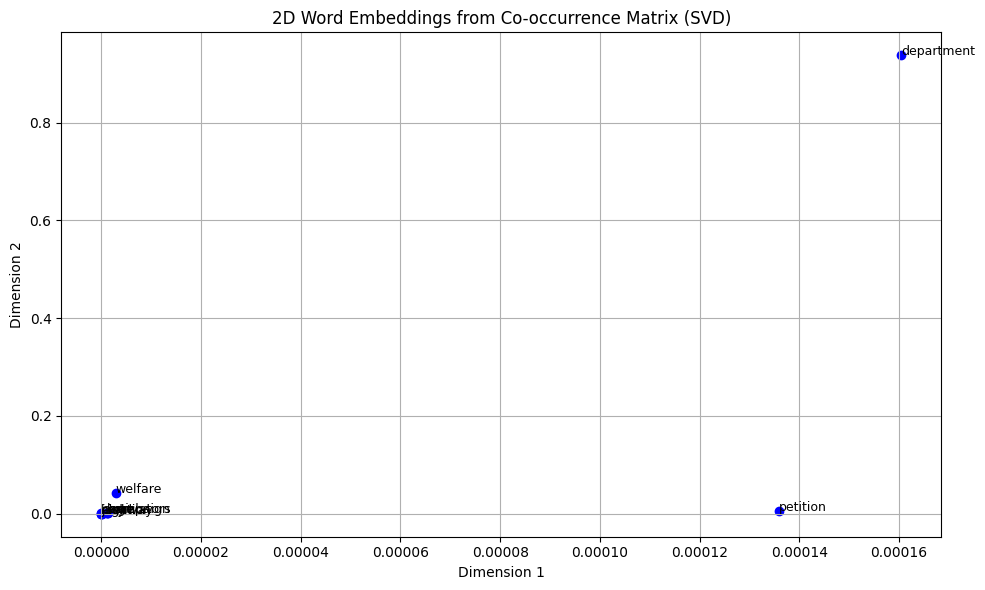

In [15]:
# words = [
#     "jury", "investigation", "court", "prison", 
#     "mayor", "legislators", "laws", "committee", "government", "department",
#     "governor", "election", "campaign", "candidate", "voters", "petition",
#     "resolution", "house", "doctor", "intern"
# ]
words = ["jury", "election", "campaign", "vote", "petition", "legislators", "welfare", "highway", "court", "department"]

M_reduced = reduce_to_k_dim(co_matrix)

title = "2D Word Embeddings from Co-occurrence Matrix (SVD)"
plot_embeddings(M_reduced, words, title)

## Prediction-Based Word Vectors
In this section, we load pre-trained word vectors using the **GloVe** embeddings from the [Stanford NLP paper on GloVe](https://nlp.stanford.edu/pubs/glove.pdf). The pre-trained embeddings provide rich semantic information about words based on large text corpora, allowing us to represent words as vectors that capture their meaning and relationships.

Steps:
1. **Load GloVe Word Vectors**: We use the GloVe embeddings from the `glove-wiki-gigaword-200` model, which has 200-dimensional vectors for each word.
2. **Vocabulary Matching**: We map the words from our corpus to the GloVe vocabulary and extract the corresponding vectors.
3. **Dimensionality Reduction**: After obtaining the word vectors, we reduce the dimensionality to visualize the embeddings in 2D space, allowing us to explore word relationships visually.

This is an excellent opportunity to explore how pre-trained embeddings like GloVe can be used to improve downstream NLP tasks by providing richer word representations.

In [18]:
# Do not edit
import gensim.downloader as api
import numpy as np
wv_from_bin = api.load("glove-wiki-gigaword-200")
print("Loaded vocab size %i" % len(list(wv_from_bin.index_to_key)))

wv_words = list(wv_from_bin.index_to_key)
unique_tokens = set(tokens)
word2ind = {}
M = []
idx = 0
print('rendering M based on wv')
for w in wv_words:
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass

print('rendering M based on unique_tokens')
for w in unique_tokens:
    if w in wv_words:
        continue
    try:
        M.append(wv_from_bin.get_vector(w))
        word2ind[w] = idx
        idx += 1
    except:
        pass

Loaded vocab size 400000
rendering M based on wv
rendering M based on unique_tokens


In [19]:
M = np.stack(M)
M_reduced = reduce_to_k_dim(M, k=2)
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis]

### Compare plots
What stands out when comparing the two different ways of embedding using the given words?

(Use this to help answer the question in your assignment document).

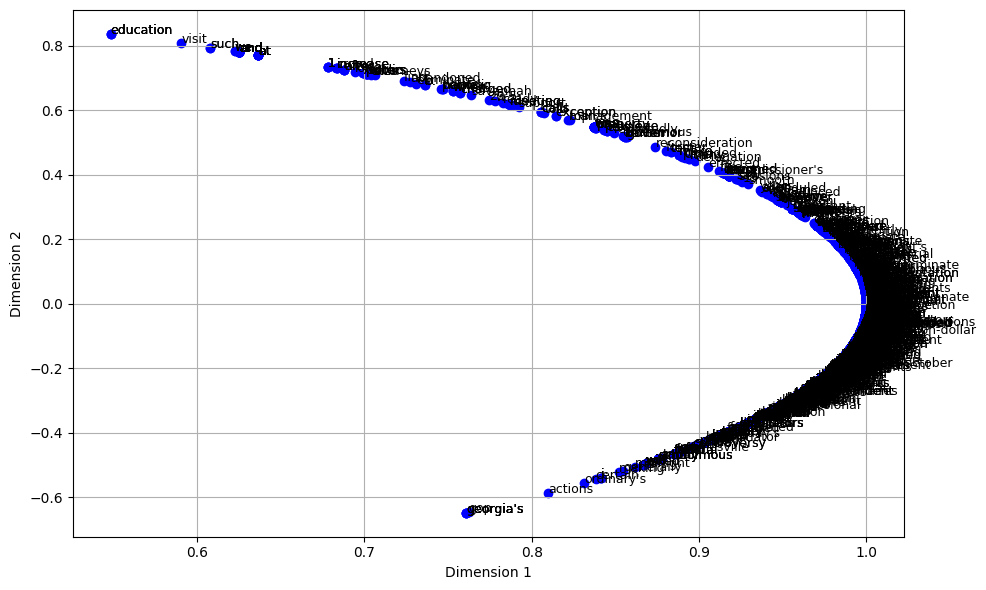

In [20]:
plot_embeddings(M_reduced_normalized, tokens)

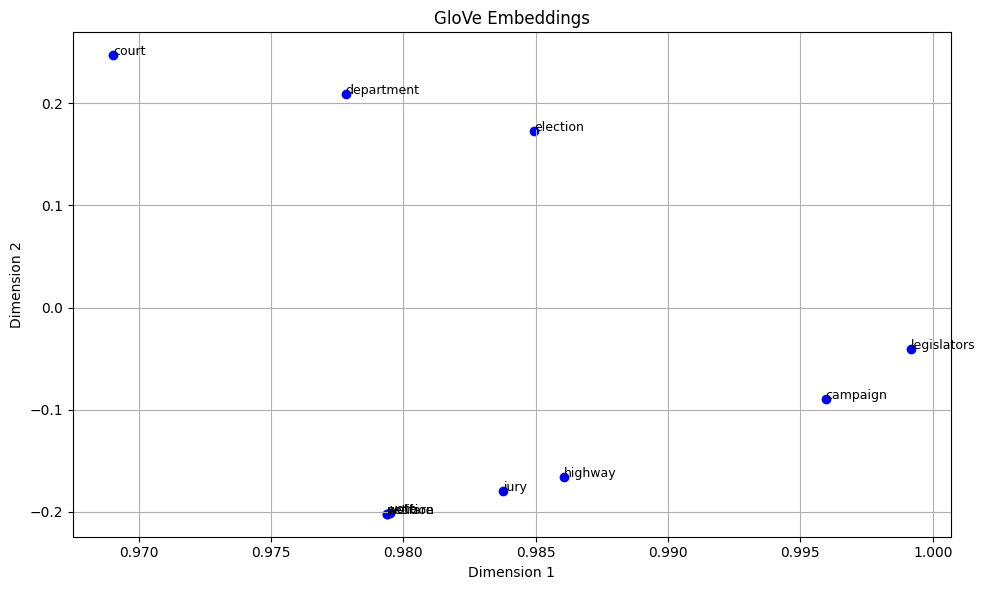

In [21]:
# words = [
#     "jury", "investigation", "court", "prison", 
#     "mayor", "legislators", "laws", "committee", "government", "department",
#     "governor", "election", "campaign", "candidate", "voters", "petition",
#     "resolution", "house", "doctor", "intern"
# ]
words = [
    "jury", "election", "campaign", "vote", "petition", "legislators", "welfare", "highway", "court", "department",]
plot_embeddings(M_reduced_normalized, words, "GloVe Embeddings")

### Words with multiple meanings
Polysemes and homonyms are words that have more than one meaning (see [this wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms). Your task is to find a word with at least two different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from both meanings.

For example:
- "leaves" has both the "go_away" and "a_structure_of_a_plant" meanings in the top 10.
- "scoop" has both "handed_waffle_cone" and "lowdown" meanings in the top 10.

You will probably need to try several polysemous or homonymic words before you find one.

Once you discover a word that fits this criterion, state the word and explain the multiple meanings that occur in the top 10. Reflect on why many of the polysemous or homonymic words you tried didn’t work (i.e., why the top-10 most similar words only contain one of the word's meanings).

**Note**: Use the `wv_from_bin.most_similar(word)` function to get the top 10 most similar words. This function ranks all other words in the vocabulary based on their cosine similarity to the given word. For further assistance, you can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html).

In [17]:
# word with at least two different meanings:
wv_from_bin.most_similar("seal")

[('seals', 0.7311047911643982),
 ('sealing', 0.6171486377716064),
 ('sealed', 0.5628460645675659),
 ('crabeater', 0.45116424560546875),
 ('pelts', 0.4378356635570526),
 ('remove', 0.430713951587677),
 ('wrap', 0.42121368646621704),
 ('coat', 0.42117998003959656),
 ('airtight', 0.408542662858963),
 ('protect', 0.4069032371044159)]

<span style="color:blue">

There are mainly two meanings conveyed here: "the animal", and "to close or protect something"

- seals = both meanings
- sealing	= Closing something
- sealed	= Closed
- crabeater = Type of seal (animal meaning)
- pelts = Animal fur (animal meaning)
- remove = Vague, but contextually opposite of sealing
- wrap = Related to sealing/covering
- coat = Related to outer covering (overlaps with both)
- airtight = Related to sealing something
- protect	= Related to sealing/covering

</span>

In [18]:
# word that didn't work
wv_from_bin.most_similar("rock")

[('band', 0.694769561290741),
 ('pop', 0.674067497253418),
 ('punk', 0.6610648036003113),
 ('bands', 0.6459488272666931),
 ("'n'", 0.6244866847991943),
 ('rocks', 0.6163124442100525),
 ('album', 0.6133195161819458),
 ('albums', 0.6000897884368896),
 ('music', 0.5990884900093079),
 ('rap', 0.5837082266807556)]

<span style="color:blue">There is **mainly** one meaning here: "music"</span>

<span style="color:blue">Many polysemous words did not reflect multiple meanings, likely because GloVe assigns a single vector to each word. As a result, the most frequent sense in the training data tends to dominate the embedding, overshadowing less common meanings and preventing them from appearing among the top similar words.</span>



### Synonyms
When considering **Cosine Similarity**, it's often useful to think of **Cosine Distance**, which is simply 1 - Cosine Similarity.

Find three words \( (w_1, w_2, w_3) \) where:
- \(w_1\) and \(w_2\) are **synonyms**.
- \(w_1\) and \(w_3\) are **antonyms**.

However, you need to find a case where **Cosine Distance** \( (w_1, w_3) < \text{Cosine Distance} (w_1, w_2) \). In other words, the antonym is **closer** to the word than its synonym in the vector space.

For example, "happy" (\(w_1\)) may be closer to "sad" (\(w_3\)) than to "cheerful" (\(w_2\)), which is counter-intuitive since we expect synonyms to be closer than antonyms.

Once you find such an example, provide a possible explanation for why this result may have occurred.

Use the `wv_from_bin.distance(w1, w2)` function to compute the cosine distance between two words. You can refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for further assistance.







In [19]:
w1 = "happy"
w2 = "cheerful"
w3 = "sad"

print(wv_from_bin.distance(w1, w2))
print(wv_from_bin.distance(w1, w3))

0.5172466933727264
0.40401363372802734


In [20]:
w1 = "fast"
w2 = "quick"
w3 = "slow"

print(wv_from_bin.distance(w1, w2))
print(wv_from_bin.distance(w1, w3))

0.3328641653060913
0.2522680163383484


<span style="color:blue">

Possible Explanation:
Antonyms often appear in similar contexts (e.g., "I feel happy/sad today"). Since GloVe is trained on co-occurrence statistics, it places words that appear in similar environments close together, even if their meanings are opposite. On the other hand, "cheerful" may be used in slightly different contexts or be less frequent in the corpus, causing it to end up farther away.

Similarly, the result where **"fast"** is closer to **"slow"** than to **"quick"** could be due to contextual usage. **"Fast"** and **"slow"** might appear in similar contexts (e.g., "moving slow" or "moving fast"), leading the model to map them closer together.

</span>

### Analogies
Word vectors have demonstrated the ability to solve analogies based on their learned semantic relationships. For instance, consider the analogy:

**"man : grandfather :: woman : x"**

(Read: man is to grandfather as woman is to x). Using word vectors, we can find the word \(x\) that completes the analogy.

In the example provided, we use the `most_similar` function from the Gensim library. This function identifies words that are most similar to the words in the positive list and most dissimilar to those in the negative list. For analogy solving, it effectively computes:

\[ \text{word}(x) = \text{most similar to} (\text{woman} + \text{grandfather} - \text{man}) \]

The result is the word with the highest cosine similarity to the target vector. You can use this approach to explore various analogies and gain insights into the semantic structure of word vectors.

Refer to the [Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html) for more details on the `most_similar` function and how word vectors handle analogy-solving tasks.

In [21]:
# Run this cell to answer the analogy -- man : grandfather :: woman : x
print(wv_from_bin.most_similar(positive=['woman', 'grandfather'], negative=['man']))

[('grandmother', 0.7608445286750793), ('granddaughter', 0.7200808525085449), ('daughter', 0.7168302536010742), ('mother', 0.7151536345481873), ('niece', 0.7005682587623596), ('father', 0.6659887433052063), ('aunt', 0.6623408794403076), ('grandson', 0.6618767976760864), ('grandparents', 0.6446609497070312), ('wife', 0.644535481929779)]


### Bias in word vectors
a. **Observation**: Consider the results of a word vector model when queried with analogies involving "man", "woman", and "profession". What are the top results returned by the model for each query?

<span style="color:blue">Top results returned for "woman : profession :: man : x" are: "reputation", "professions", "skill", "skills", "ethic", "business", "respected", "practice", "regarded" and "life"</span>

<span style="color:blue">Top results returned for "man : profession :: woman : x" are: "professions", "practitioner", "teaching", "nursing", "vocation", "teacher", "practicing", "educator", "physicians", and "professionals". </span>


b. **Analysis**: Do you observe any gender biases in the results? For example, are certain professions more closely associated with "man" or "woman" based on the word vectors? Discuss how word embeddings might perpetuate societal biases present in the training data.

<span style="color:blue">Yes, there is evidence of gender bias. "Man" is associated with traits like reputation and skill. "Woman" is associated with roles like nursing, teaching, and educator, which reflects traditional professions per gender.
Word embeddings might perpetuate societal biases by reflecting stereotypes and professional biases present in the training data. </span>

c. **Reflection**: How might such biases affect the fairness of machine learning models that use word embeddings? Suggest potential strategies for mitigating gender bias in word vector models.

<span style="color:blue"> Bias in embeddings can lead to unfair model behavior, for example: stereotyping in job recommendation systems.
Possible mitigation strategies include: </span>
- <span style="color:blue">More balanced datasets,</span>
- <span style="color:blue">Neutralizing: Removing gender components from words that should be gender-neutral (e.g., "doctor", "nurse"), ensuring they don't align with the gender direction in the embedding space.</span>
- <span style="color:blue">Equalizing: Ensuring that word pairs like ("man", "woman") are equidistant from gender-neutral words.</span>
</span>

<span style="color:blue">source: https://towardsdatascience.com/tackling-gender-bias-in-word-embeddings-c965f4076a10/</span>

In [22]:
print(wv_from_bin.most_similar(positive=['man', 'profession'], negative=['woman']))
print()
print(wv_from_bin.most_similar(positive=['woman', 'profession'], negative=['man']))

[('reputation', 0.5250176787376404), ('professions', 0.5178037881851196), ('skill', 0.49046966433525085), ('skills', 0.49005505442619324), ('ethic', 0.4897659420967102), ('business', 0.487585186958313), ('respected', 0.485920250415802), ('practice', 0.4821045696735382), ('regarded', 0.4778572618961334), ('life', 0.4760662019252777)]

[('professions', 0.5957458019256592), ('practitioner', 0.4988412857055664), ('teaching', 0.48292139172554016), ('nursing', 0.48211804032325745), ('vocation', 0.4788965880870819), ('teacher', 0.47160351276397705), ('practicing', 0.4693780839443207), ('educator', 0.46524327993392944), ('physicians', 0.4628995656967163), ('professionals', 0.46013936400413513)]
